# Imports, Physical Channels, Qubit Definitions, Functions
Always run this section

In [2]:
from pathlib import Path
import datetime
from datetime import date
import pandas as pd
import time
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
import sys
import logging
import math as m
import statistics as stat

from qcodes.instrument_drivers.yokogawa.GS200 import GS200

from laboneq.simple import *
import laboneq.pulse_sheet_viewer.pulse_sheet_viewer as psv
from laboneq.contrib.example_helpers.plotting.plot_helpers import plot_simulation
from laboneq.contrib.example_helpers.descriptors.shfsg_shfqa_pqsc import (
    descriptor_shfsg_shfqa_pqsc,
)
from laboneq.analysis.fitting import (
    lorentzian,
    oscillatory,
    oscillatory_decay,
    exponential_decay,
)

In [3]:
# Just be careful about the drive lines.
descriptor_shfqc = """
instruments:
  SHFQC:
  - address: DEV12195
    uid: device_shfqc
    interface: 1gbe
    options: SHFQC/PLUS/QC6CH

connections:
  device_shfqc:
    - iq_signal: q0/drive_line
      ports: SGCHANNELS/0/OUTPUT

    - iq_signal: q0/measure_line
      ports: [QACHANNELS/0/OUTPUT]
    - acquire_signal: q0/acquire_line
      ports: [QACHANNELS/0/INPUT]

    - iq_signal: q1/drive_line
      ports: SGCHANNELS/1/OUTPUT

    - iq_signal: q1/measure_line
      ports: [QACHANNELS/0/OUTPUT]
    - acquire_signal: q1/acquire_line
      ports: [QACHANNELS/0/INPUT]
      
    - iq_signal: q2/drive_line
      ports: SGCHANNELS/1/OUTPUT
      
    - iq_signal: q2/measure_line
      ports: [QACHANNELS/0/OUTPUT]
    - acquire_signal: q2/acquire_line
      ports: [QACHANNELS/0/INPUT]
"""

The logical signal group is what defines the set of logical parameters for measurements. This needs to get assigned to an experimental signal group in the Experiment class connecting theory with device_setup (shown later).

In [4]:
# Define and Load our Device Setup
device_setup = DeviceSetup.from_descriptor(
    yaml_text=descriptor_shfqc, # the yaml gives the full description of the logical signal layout
    server_host="localhost",  # ip address of the LabOne dataserver used to communicate with the instruments
    server_port="8004",  # port number of the dataserver - default is 8004
    setup_name="my_setup",  # setup name
)

# define shortcut to logical signals for convenience
lsg = {
    qubit_name: device_setup.logical_signal_groups[qubit_name].logical_signals
    for qubit_name in device_setup.logical_signal_groups.keys()
}

In [206]:
# GKP1
q0 = Transmon.from_logical_signal_group(
    uid="q0",
    lsg=device_setup.logical_signal_groups["q0"],
    parameters=TransmonParameters(
        resonance_frequency_ge=3e9,
        readout_resonator_frequency=7.11121e9,
        readout_lo_frequency=7.2e9,
        readout_integration_delay=95e-9,
        readout_range_out=-5,
        readout_range_in=5,
        drive_lo_frequency=3e9,
        drive_range=0,
        user_defined={
            "amplitude_pi": 1,
            "pulse_length": 50e-9,
            "readout_len": 2e-6,
            "readout_amp": 0.9,
            "reset_length": 5e-6,
        }
    )
)

#Test Transmon (T0)
q1 = Transmon.from_logical_signal_group(
    uid="q1",
    lsg=device_setup.logical_signal_groups["q1"],
    parameters=TransmonParameters(
        resonance_frequency_ge=4.919995e9,
        readout_resonator_frequency=6.4207e9,
        readout_lo_frequency=6.4e9,
        readout_integration_delay=95e-9,
        readout_range_out=0, #should be 0
        readout_range_in=5, #should be 5
        drive_lo_frequency=4.8e9,
        drive_range=-5,
        user_defined={
            "amplitude_pi/2": 0.5,
            "amplitude_pi": 0.5*2,
            "pulse_length": 100e-9,
            "readout_len": 2e-6,
            "readout_amp": 0.4,
            "reset_length": 100e-6,
        }
    )
)

#Fluxionium 1
q2 = Transmon.from_logical_signal_group( 
    uid="q2",
    lsg=device_setup.logical_signal_groups["q2"],
    parameters=TransmonParameters(
        resonance_frequency_ge=2e9,
        readout_resonator_frequency=6.73e9,
        readout_lo_frequency=6.8e9,
        readout_integration_delay=93e-9,
        readout_range_out=-10,
        readout_range_in=5,
        drive_lo_frequency=6e9,
        drive_range=-10,
        user_defined={
            "amplitude_pi": 0.425,
            "pulse_length": 100e-9,
            "readout_len": 2e-6,
            "readout_amp": 1,
            "reset_length": 5e-6,
            "readout_power": -10 #max power in dBm for readout pre_punchout
        }
    )
)

qubit=q1 #Defines which qubit we are actually doing all the measuring of. Important.
averages=2**10
device_setup.set_calibration(qubit.calibration()) #This sets the settings defined in the qubit params
# device_setup.get_calibration() #Here for checking if all the calibration went well.

In [207]:
readout_pulse = pulse_library.gaussian_square(
    uid=f"readout_pulse_{qubit.uid}",
    length=qubit.parameters.user_defined['readout_len'],
    amplitude=qubit.parameters.user_defined['readout_amp'],
    width=qubit.parameters.user_defined['readout_len']*0.9,
    sigma=0.2,)

# Connect to Yoko

In [ ]:
try:
    dc = GS200('yoko_right', address = 'TCPIP0::192.168.4.157::inst0::INSTR')
except Exception as e:
    print(e)

try:
    coil= GS200('yoko_left', address = 'TCPIP0::192.168.4.208::inst0::INSTR')
except Exception as e:
    print(e)

In [ ]:
# dc.BNC_out.set('ready') # this sets a low signal signaure right after the move has been completed
# dc.BNC_out.get()
# dc.ramp_current(0e-3, 1e-6,0.02)
# dc.output('off')
dc.source_mode('CURR')
dc.ramp_current(0e-3, 1e-6,0.02)
dc.output('on')
dc.current_range(0.01)

# coil.BNC_out.set('ready') # this sets a low signal signature right after the move has been completed
# coil.BNC_out.get()
# coil.ramp_current(0e-3, 1e-6,0.02)
# coil.output('off')
coil.source_mode('CURR')
coil.ramp_current(0e-3, 1e-6,0.02)
coil.output('on')
coil.current_range(0.01)

# dc.current.get()
# coil.current.get()

## Defining Real-Time Calls
Seems as if the QCoDes intruments cannot be pickled into the experiment when it is sent to the HFSQC. To get around this, do not pass the QCoDes object as a parameter to the call. Just have that name be in the global namespace which makes sure it is handled by the computer.

In [11]:
def change_dc_current(session, new_current, step_time):
    dc.ramp_current(new_current, 1e-6, step_time)
    # print("DC Current " + str(new_current))

def change_coil_current(session, new_current, step_time):
    coil.ramp_current(new_current, 1e-6, step_time)
    print("Current coil current: " + str(new_current))
    
def sweep_progress(session, linearsweepparameter):
    print(str(linearsweepparameter.count))

# Single Resonator Point Pulsed Measurement

In [7]:
# Is now working now that there is a kernel for the integration (in integration mode). For ease, I am having the kernel be the same as the applied drive pulse.
exp = Experiment(
    uid="Single Point Readout",
    signals=[
        ExperimentSignal(uid="measure", map_to=lsg[qubit.uid]['measure_line']),
        ExperimentSignal(uid="acquire", map_to=lsg[qubit.uid]['acquire_line']),
        ExperimentSignal(uid="drive", map_to=lsg[qubit.uid]['drive_line'])
    ]
)

with exp.acquire_loop_rt(
    uid='shots',
    count=averages,
    averaging_mode=AveragingMode.CYCLIC,
    acquisition_type=AcquisitionType.INTEGRATION,
):
    with exp.section(uid="Pulsed Single Frequency Readout"):
        exp.play(
            signal="measure",
            pulse=readout_pulse
        )
        exp.acquire( #acquire on its own seems to be able to measure things, but not as well(?)
            signal='acquire',
            handle='single_freq_data',
            length=qubit.parameters.user_defined['readout_len'],
            kernel=readout_pulse #this is important to actually integrate against so the result is non-zero
        )
    with exp.section(uid="delay_between_readout", length=qubit.parameters.user_defined['reset_length']):
        exp.reserve(signal='measure')

## Compile Session
Do final checks before running the job.

In [9]:
session = Session(
    device_setup=device_setup,
    log_level = logging.WARNING,
    experiment=exp)
session.connect(use_async_api=True);
compiled_session = session.compile(exp);
# psv.interactive_psv(compiled_session, max_events_to_publish=10000,)

## Run session
- Think about how to implement session.queue() since this could allow the device to always be measuring something

In [10]:
results = session.run()
my_results = session.get_results() #a deep copy of session.results
my_acquired_results = my_results.acquired_results['single_freq_data'] #extracts data from the exp.acquire method with the same key name

## Plot and Analyze Data

In [12]:
# Just one data point... so not much to see here...
print(np.abs(my_acquired_results.data))
my_acquired_results

11.710818604710092


AcquiredResult(data=(11.696783979086124+0.5731639721913774j), axis_name=[], axis=[], last_nt_step=[], handle='single_freq_data')

# Readout Resonator Trace (Global)

In [6]:
# Full frequency span for readout resonator
readout_lo_freq_sweep = LinearSweepParameter(
    uid='Readout_LO', start=4e9, stop=8e9, count=5)

readout_freq_sweep = LinearSweepParameter(
    uid='Readout_Frequency', start=-500e6, stop=495e6, count=101)

exp = Experiment(
    uid="Resonator Trace",
    signals=[
        ExperimentSignal(uid="measure", map_to=lsg[qubit.uid]['measure_line']),
        ExperimentSignal(uid="acquire", map_to=lsg[qubit.uid]['acquire_line']),
        ExperimentSignal(uid="drive", map_to=lsg[qubit.uid]['drive_line'])
    ]
)
with exp.sweep(
    uid='Readout LO Frequency Sweep',
    parameter=readout_lo_freq_sweep
):
    with exp.acquire_loop_rt(
        uid='shots',
        count=averages,
        averaging_mode=AveragingMode.CYCLIC,
        acquisition_type=AcquisitionType.SPECTROSCOPY,
    ):
        with exp.sweep(
            uid='Readout Frequency Sweep',
            parameter=readout_freq_sweep,
            reset_oscillator_phase=True
        ):
            with exp.section(uid="Pulsed Single Frequency Readout"):
                exp.play(
                    signal="measure",
                    pulse=readout_pulse
                )
                exp.acquire( #acquire on its own seems to be able to measure things, but not as well(?)
                    signal='acquire',
                    handle='single_freq_data',
                    length=qubit.parameters.user_defined['readout_len'],
                )
            with exp.section(uid="delay_between_readout", length=qubit.parameters.user_defined['reset_length']):
                exp.reserve(signal="measure")

exp_calibration = Calibration()
readout_osc = Oscillator(
    "readout_osc",
    frequency=readout_freq_sweep,
    modulation_type=ModulationType.HARDWARE)
readout_lo = Oscillator(
    "readout_lo",
    frequency=readout_lo_freq_sweep,
    modulation_type=ModulationType.HARDWARE)
exp_calibration["measure"] = SignalCalibration(
    oscillator=readout_osc,
    local_oscillator=readout_lo)
exp_calibration["acquire"] = SignalCalibration(
    oscillator=readout_osc,
    local_oscillator=readout_lo)
exp.set_calibration(exp_calibration)

## Compile Session
Do final checks before running the job.

In [7]:
session = Session(
    device_setup=device_setup,
    log_level = logging.WARNING,
    experiment=exp)
session.connect(use_async_api=True);
compiled_session = session.compile(exp);
# psv.interactive_psv(compiled_session, max_events_to_publish=10000,)

## Run session
- Think about how to implement session.queue() since this could allow the device to always be measuring something

In [8]:
results = session.run()
my_results = session.get_results() #a deep copy of session.results
my_acquired_results = my_results.acquired_results['single_freq_data'] #extracts data from the exp.acquire method with the same key name

## Plot and Analyze Data

In [9]:
lo_array = my_acquired_results.axis[0]
AWG_freqs = my_acquired_results.axis[1]
freqs = np.empty((0))
for lo in lo_array:
    freqs = np.append(freqs, lo + AWG_freqs,)

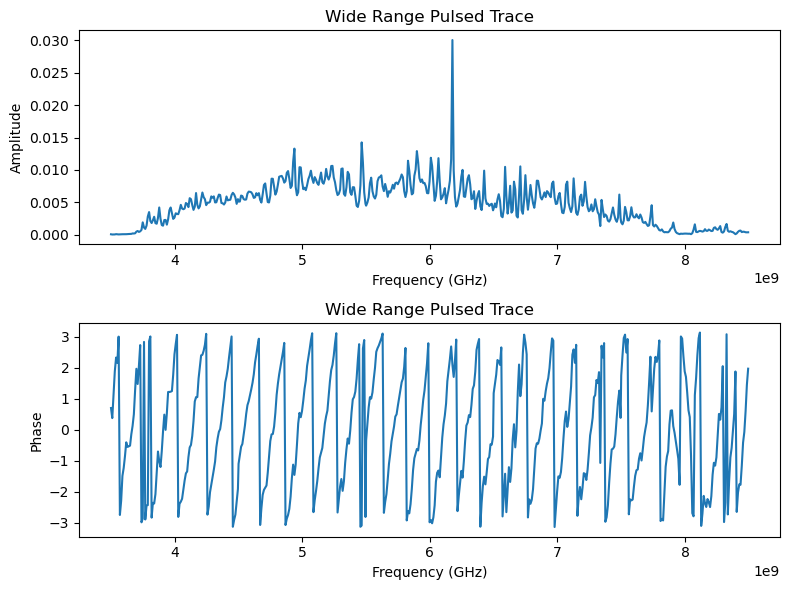

In [10]:
# For plotting current vs single resonator point
IQ_data = my_acquired_results.data.ravel()
amplitude = np.abs(IQ_data)
phase = np.angle(IQ_data)

fig, ax = plt.subplots(2,1, figsize=(8,6))
ax[0].plot(freqs, amplitude)
ax[0].set_title('Wide Range Pulsed Trace')
ax[0].set_xlabel('Frequency (GHz)')
ax[0].set_ylabel('Amplitude')
ax[1].plot(freqs, phase)
ax[1].set_title('Wide Range Pulsed Trace')
ax[1].set_xlabel('Frequency (GHz)')
ax[1].set_ylabel('Phase')
fig.tight_layout()

# Readout Resonator Trace (Localized)
- Actually just works to put in the frequency values for start and stop. The LO will adjust as necessary on the backend. Nice.

In [11]:
lo_freq_offset = qubit.parameters.readout_resonator_frequency-qubit.parameters.readout_lo_frequency

ro_frequency_sweep = LinearSweepParameter(
    uid='Readout_Frequency_Sweep',
    start=lo_freq_offset-5e6,
    stop=lo_freq_offset+5e6,
    count=101)

exp = Experiment(
    uid="Resonator Trace",
    signals=[
        ExperimentSignal(uid="measure", map_to=lsg[qubit.uid]['measure_line']),
        ExperimentSignal(uid="acquire", map_to=lsg[qubit.uid]['acquire_line']),
        ExperimentSignal(uid="drive", map_to=lsg[qubit.uid]['drive_line'])
    ]
)

with exp.acquire_loop_rt(
    uid='shots',
    count=averages,
    averaging_mode=AveragingMode.CYCLIC,
    acquisition_type=AcquisitionType.SPECTROSCOPY,
):
    with exp.sweep(
        uid='Readout Frequency Sweep',
        parameter=ro_frequency_sweep,
        reset_oscillator_phase=True
    ):
        with exp.section(uid="Pulsed Single Frequency Readout"):
            exp.play(
                signal="measure",
                pulse=readout_pulse
            )
            exp.acquire( #acquire on its own seems to be able to measure things, but not as well(?)
                signal='acquire',
                handle='single_freq_data',
                length=qubit.parameters.user_defined['readout_len'],
            )
        with exp.section(uid="delay_between_readout", length=qubit.parameters.user_defined['reset_length']):
            exp.reserve(signal="measure")

exp_calibration = Calibration()
readout_osc = Oscillator(
    "readout_osc",
    frequency=ro_frequency_sweep,
    modulation_type=ModulationType.HARDWARE,)
exp_calibration["measure"] = SignalCalibration(
    oscillator=readout_osc)
exp_calibration["acquire"] = SignalCalibration(
    oscillator=readout_osc,)
exp.set_calibration(exp_calibration)

## Compile Session
Do final checks before running the job.

In [12]:
session = Session(
    device_setup=device_setup,
    log_level = logging.WARNING,
    experiment=exp)
session.connect(use_async_api=True);
compiled_session = session.compile(exp);
# psv.interactive_psv(compiled_session, max_events_to_publish=10000,)

## Run session
- Think about how to implement session.queue() since this could allow the device to always be measuring something

In [13]:
results = session.run()
my_results = session.get_results() #a deep copy of session.results
my_acquired_results = my_results.acquired_results['single_freq_data'] #extracts data from the exp.acquire method with the same key name

## Plot and Analyze Data

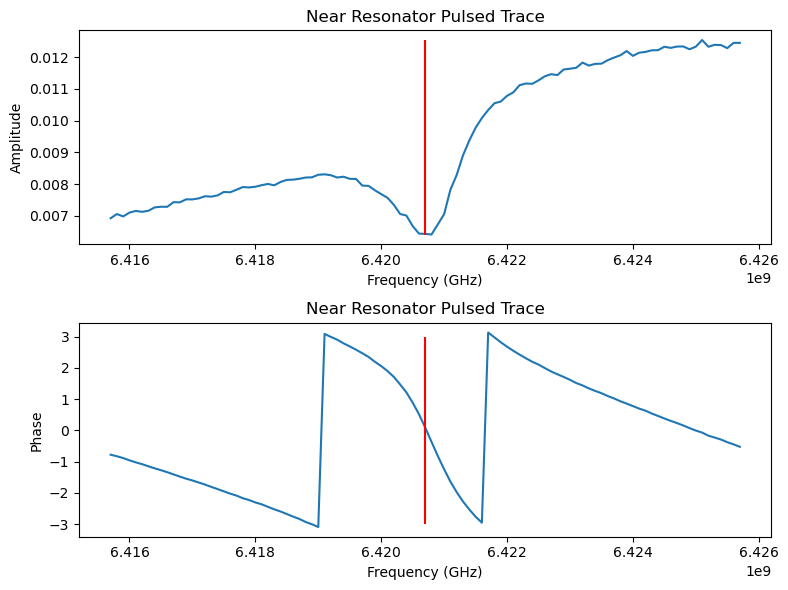

In [14]:
# For plotting current vs single resonator point
freqs = my_acquired_results.axis[0] + qubit.parameters.readout_lo_frequency
IQ_data = my_acquired_results.data
amplitude = np.abs(IQ_data)
phase = np.angle(IQ_data)

fig, ax = plt.subplots(2,1, figsize=(8,6))
ax[0].plot(freqs, amplitude)
ax[0].set_title('Near Resonator Pulsed Trace')
ax[0].set_xlabel('Frequency (GHz)')
ax[0].set_ylabel('Amplitude')
ax[1].plot(freqs, phase)
ax[1].set_title('Near Resonator Pulsed Trace')
ax[1].set_xlabel('Frequency (GHz)')
ax[1].set_ylabel('Phase')
fig.tight_layout()
ax[0].vlines(qubit.parameters.readout_resonator_frequency, np.min(amplitude), np.max(amplitude), colors='r');
ax[1].vlines(qubit.parameters.readout_resonator_frequency, -3, 3, colors='r');

# Punchout
This works, but the power sweep is NEAR_TIME. Putting it in the REAL_TIME section makes the play channel seem like there are multiple envelopes for the readout pulse? Might be becasue of some timing or alignement issue... For now it seems fine given that the loop only needs to be executed a handful of times.

In [530]:
#Note this is a power sweep of the pulse amplitude, not of powers! The conversion from amplitude to powers is squared.
lo_freq_offset = qubit.parameters.readout_resonator_frequency-qubit.parameters.readout_lo_frequency

readout_pulse_punchout = pulse_library.gaussian_square(
    uid=f"readout_pulse_{qubit.uid}",
    length=qubit.parameters.user_defined['readout_len'],
    amplitude=1,
    width=qubit.parameters.user_defined['readout_len']*0.9,
    sigma=0.2,)

ro_frequency_sweep = LinearSweepParameter(
    uid='Readout_Frequency_Sweep',
    start=lo_freq_offset-10e6,
    stop=lo_freq_offset+10e6,
    count=51) 

power_sweep = SweepParameter(
    uid='Readout_Power', values=np.logspace(start=-2,stop=0,num=20,base=10))

exp = Experiment(
    uid="Punchout",
    signals=[
        ExperimentSignal(uid="measure", map_to=lsg[qubit.uid]['measure_line']),
        ExperimentSignal(uid="acquire", map_to=lsg[qubit.uid]['acquire_line']),
        ExperimentSignal(uid="drive", map_to=lsg[qubit.uid]['drive_line'])
    ]
)

with exp.sweep(
    uid='Power sweep',
    parameter=power_sweep,
):
    with exp.acquire_loop_rt(
        uid='shots',
        count=averages,
        averaging_mode=AveragingMode.CYCLIC,
        acquisition_type=AcquisitionType.SPECTROSCOPY,
    ):
    
        with exp.sweep(
            uid='Readout_Frequency_Sweep',
            parameter=ro_frequency_sweep,
            reset_oscillator_phase=True
        ):
            with exp.section(uid="single_res_point_readout"):
                exp.play(
                    signal="measure",
                    pulse=readout_pulse_punchout,
                    amplitude=power_sweep,
                )
                exp.acquire(
                    signal='acquire',
                    handle='single_freq_data',
                    length=qubit.parameters.user_defined['readout_len'],
                )
            with exp.section(uid="delay_between_readout", length=qubit.parameters.user_defined['reset_length']):
                exp.reserve(signal="measure")

exp_calibration = Calibration()
readout_osc = Oscillator(
    "readout_osc",
    frequency=ro_frequency_sweep,
    modulation_type=ModulationType.HARDWARE)
exp_calibration["measure"] = SignalCalibration(
    oscillator=readout_osc,)
exp_calibration["acquire"] = SignalCalibration(
    oscillator=readout_osc,)
exp.set_calibration(exp_calibration)

## Compile Session
Do final checks before running the job.

In [531]:
session = Session(
    device_setup=device_setup,
    log_level = logging.WARNING,
    experiment=exp)
session.connect(use_async_api=True);
compiled_session = session.compile(exp);
# psv.interactive_psv(compiled_session, max_events_to_publish=100,)

## Run session
- Think about how to implement session.queue() since this could allow the device to always be measuring something

In [532]:
results = session.run()
my_results = session.get_results() #a deep copy of session.results
my_acquired_results = my_results.acquired_results['single_freq_data'] #extracts data from the exp.acquire method with the same key name

## Plot and Analyze Data

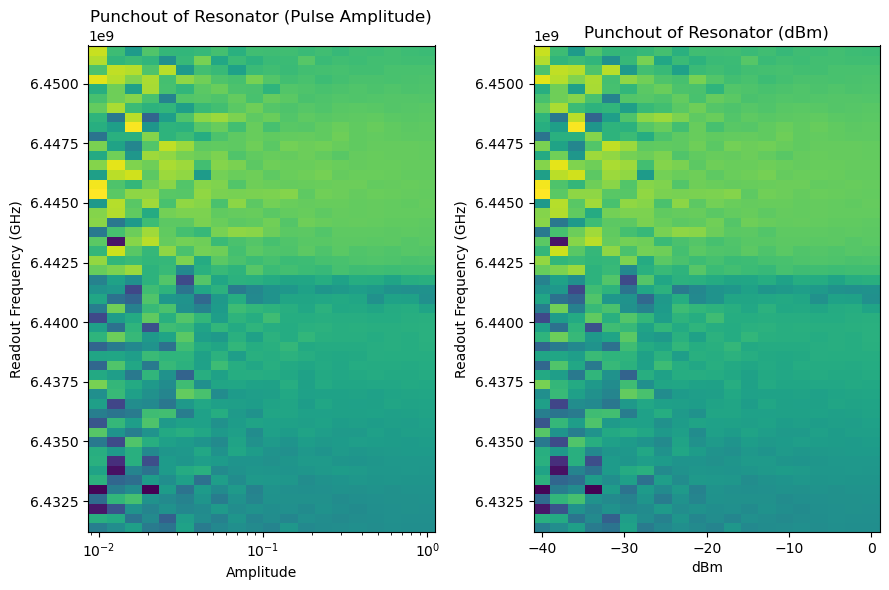

In [535]:
# For plotting punchout
IQ_data = my_acquired_results.data
phase_data = np.angle(IQ_data)
normalized_amp_data = np.divide(np.abs(IQ_data).T, np.mean(np.abs(IQ_data), axis=1))
normalized_dB_data = np.log10(normalized_amp_data)

amplitude = my_acquired_results.axis[0]
power = 10*np.log10(amplitude**2)+qubit.parameters.readout_range_out

RO_freqs = my_acquired_results.axis[1]+qubit.parameters.readout_resonator_frequency

graphing_data = normalized_dB_data #could be the phase_data too
fig, ax = plt.subplots(1,2, figsize=(9,6))
ax[0].pcolor(amplitude,
             RO_freqs,
             graphing_data,
             shading='nearest')
ax[0].set_title('Punchout of Resonator (Pulse Amplitude)')
ax[0].set_xlabel('Amplitude')
ax[0].set_ylabel('Readout Frequency (GHz)')
ax[0].set_xscale('log')
ax[1].pcolor(power,
             RO_freqs,
             graphing_data,
             shading='nearest')
ax[1].set_title('Punchout of Resonator (dBm)')
ax[1].set_xlabel('dBm')
ax[1].set_ylabel('Readout Frequency (GHz)')
fig.tight_layout()

# 1D Flux Sweep

In [49]:
dc_sweep_param = LinearSweepParameter(
    uid='DC Current', start=0e-6, stop=4e-6, count=5)

coil_sweep_param = LinearSweepParameter(
    uid='Coil Current', start=-100e-6, stop=100e-6, count=101)

In [53]:
# This one is a direct copy of my working spectroscopy scan but now includes a 1D resonator sweep.
lo_freq_offset = qubit.parameters.readout_resonator_frequency-qubit.parameters.readout_lo_frequency

ro_frequency_sweep = LinearSweepParameter(
    uid='Readout_Frequency_Sweep',
    start=lo_freq_offset-10e6,
    stop=lo_freq_offset+10e6,
    count=101) #NOTE! This is the frequency offset from the LO. Need better integration for ease of use.

dc_sweep_param = LinearSweepParameter(
    uid='DC Current', start=0e-6, stop=4e-6, count=5)

coil_sweep_param = LinearSweepParameter(
    uid='Coil Current', start=-100e-6, stop=100e-6, count=101)

current_sweep_param = coil_sweep_param #Simply change coil_sweep_param to dc_sweep param for dc sweep.

exp = Experiment(
    uid="1D Current vs Resonator",
    signals=[
        ExperimentSignal(uid="measure", map_to=lsg[qubit.uid]['measure_line']),
        ExperimentSignal(uid="acquire", map_to=lsg[qubit.uid]['acquire_line']),
        ExperimentSignal(uid="drive", map_to=lsg[qubit.uid]['drive_line'])
    ]
)

with exp.sweep(
    uid="Yoko Sweep",
    parameter=current_sweep_param,
    execution_type=ExecutionType.NEAR_TIME,
):
    exp.call('change_current', new_current=current_sweep_param, step_time=0.01) 
    with exp.acquire_loop_rt(
        uid='shots',
        count=averages,
        averaging_mode=AveragingMode.CYCLIC,
        acquisition_type=AcquisitionType.SPECTROSCOPY,
    ):
        with exp.sweep(
                uid='Readout Resonator Frequency Sweep',
                parameter=ro_frequency_sweep,
                reset_oscillator_phase=True
            ):
                with exp.section(uid="Pulsed Single Frequency Readout"):
                    exp.play(
                        signal="measure",
                        pulse=readout_pulse
                    )
                    exp.acquire( #acquire on its own seems to be able to measure things, but not as well(?)
                        signal='acquire',
                        handle='single_freq_data',
                        length=qubit.parameters.user_defined['readout_len'],
                    )
                with exp.section(uid="delay_between_readout", length=qubit.parameters.user_defined['reset_length']):
                    exp.reserve(signal="measure")

exp_calibration = Calibration()
readout_osc = Oscillator(
    "readout_osc",
    frequency=ro_frequency_sweep,
    modulation_type=ModulationType.HARDWARE)
exp_calibration["measure"] = SignalCalibration(
    oscillator=readout_osc,)
exp_calibration["acquire"] = SignalCalibration(
    oscillator=readout_osc)
exp.set_calibration(exp_calibration)

## Compile Session
Do final checks before running the job.

In [54]:
session = Session(
    device_setup=device_setup,
    log_level = logging.WARNING,
    experiment=exp)
session.connect(use_async_api=True);
session.register_neartime_callback(change_dc_current, 'change_current')
session.register_neartime_callback(change_coil_current, 'change_current')
compiled_session = session.compile(exp);
# psv.interactive_psv(compiled_session, max_events_to_publish=10000,)

## Run session
- Think about how to implement session.queue() since this could allow the device to always be measuring something

In [ ]:
results = session.run()
my_results = session.get_results() #a deep copy of session.results
my_acquired_results = my_results.acquired_results['single_freq_data'] #extracts data from the exp.acquire method with the same key name

## Plot and Analyze Data

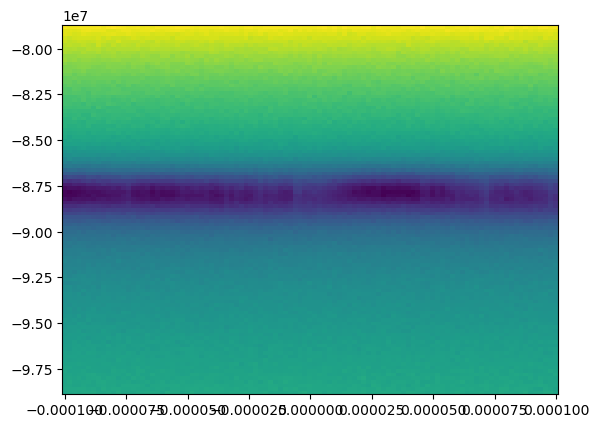

In [60]:
# For plotting 1D flux sweep
plt.pcolor(my_acquired_results.axis[0],
           my_acquired_results.axis[1], 
           np.abs(my_acquired_results.data).T,
           shading='nearest')

# 2D Flux Sweep (Inner loop is DC, Outer loop is Coil)
- Would be nice to have a faster flux sweep functionality at the end (or beginning?) of each loop

In [12]:
dc_sweep_param = LinearSweepParameter(
    uid='DC_Current', start=-400e-6, stop=400e-6, count=201)

coil_sweep_param = LinearSweepParameter(
    uid='Coil_Current', start=-100e-6, stop=100e-6, count=101)

exp = Experiment(
    uid="2D Current Sweep",
    signals=[
        ExperimentSignal(uid="measure", map_to=lsg[qubit.uid]['measure_line']),
        ExperimentSignal(uid="acquire", map_to=lsg[qubit.uid]['acquire_line']),
        ExperimentSignal(uid="drive", map_to=lsg[qubit.uid]['drive_line'])
    ]
)

with exp.sweep(
    uid='coil sweep',
    parameter=coil_sweep_param,
    execution_type=ExecutionType.NEAR_TIME,
):
    exp.call('Coil_Current', new_current=coil_sweep_param, step_time=0.01)
    with exp.sweep(
        uid="dc sweep",
        parameter=dc_sweep_param,
        execution_type=ExecutionType.NEAR_TIME,
    ):
        exp.call('DC_Current', new_current=dc_sweep_param, step_time=0.01) #note that "argument" session (first argument to the function) is automatically passed
        with exp.acquire_loop_rt(
            uid="shots",
            count=averages,
            acquisition_type=AcquisitionType.INTEGRATION,
            averaging_mode=AveragingMode.SEQUENTIAL
        ):
            with exp.section(uid="Pulsed Single Frequency Readout"):
                exp.play(
                    signal="measure",
                    pulse=readout_pulse
                )
                exp.acquire(
                    signal='acquire',
                    handle='single_freq_data',
                    kernel=readout_pulse,
                    length=qubit.parameters.user_defined['readout_len'],
                )
            with exp.section(uid="delay_between_readout", length=qubit.parameters.user_defined['reset_length']):
                exp.reserve(signal="measure")

## Compile Session
Do final checks before running the job.

In [13]:
session = Session(
    device_setup=device_setup,
    log_level = logging.WARNING,
    experiment=exp)
session.connect(use_async_api=True);
session.register_neartime_callback(change_dc_current, 'DC_Current')
session.register_neartime_callback(change_coil_current, 'Coil_Current')
compiled_session = session.compile(exp);
# psv.interactive_psv(compiled_session, max_events_to_publish=1000,)

## Run session
- Think about how to implement session.queue() since this could allow the device to always be measuring something

In [ ]:
results = session.run()
my_results = session.get_results() #a deep copy of session.results
my_acquired_results = my_results.acquired_results['single_freq_data'] #extracts data from the exp.acquire method with the same key name

## Plot and Analyze Data

In [ ]:
#plotting resonator over flux
plt.pcolor(my_acquired_results.axis[0],
           my_acquired_results.axis[1], 
           np.log(np.abs(my_acquired_results.data).T),
           shading='nearest')

# Qubit Spectroscopy (Global)
-Unclear still how to have the LO naturally move during the sweep. Maybe build it into a function call?
-For some reason, the drive frequency sweep is upset that it is in real-time. Need to investigate further.

In [536]:
drive_lo_freq_sweep = LinearSweepParameter(
    uid='Drive_LO', start=1e9, stop=8e9, count=8)

drive_freq_sweep = LinearSweepParameter(
    uid='Drive_Frequency', start=-500e6, stop=498e6, count=500)

exp = Experiment(
    uid="Spectroscopy",
    signals=[
        ExperimentSignal(uid="measure", map_to=lsg[qubit.uid]['measure_line']),
        ExperimentSignal(uid="acquire", map_to=lsg[qubit.uid]['acquire_line']),
        ExperimentSignal(uid="drive", map_to=lsg[qubit.uid]['drive_line'])
    ]
)

with exp.sweep(
    uid='Sweep Drive LO',
    parameter=drive_lo_freq_sweep
):
    with exp.acquire_loop_rt(
        uid='shots',
        count=averages,
        averaging_mode=AveragingMode.SEQUENTIAL,
        acquisition_type=AcquisitionType.INTEGRATION,
    ):
        with exp.sweep(
            uid='Drive Frequency Sweep',
            parameter=drive_freq_sweep,
        ):
            with exp.section(uid='Play drive'):
                exp.play(
                    signal="drive",
                    pulse=pulse_library.gaussian_square(
                    uid=f"drive_pulse_{qubit.uid}",
                    length=100e-9,
                    width=100e-9*0.9,
                    sigma=0.2,
                    marker = {"marker1": {"enable": True}}))
            with exp.section(
                uid="single_res_point_readout",
                play_after='Play drive',
            ):
                exp.play(
                    signal="measure",
                    pulse=readout_pulse)
                exp.acquire( #acquire on its own seems to be able to measure things, but not as well(?)
                    signal='acquire',
                    handle='single_freq_data',
                    length=qubit.parameters.user_defined['readout_len'],
                    kernel=readout_pulse #this is important to actually integrate against so the result is non-zero
                )
            with exp.section(uid="delay_between_readout", length=qubit.parameters.user_defined['reset_length']):
                exp.reserve(signal="measure")
                exp.reserve(signal="drive")

exp_calibration = Calibration()
drive_osc = Oscillator(
    "drive_osc",
    frequency=drive_freq_sweep,
    modulation_type=ModulationType.HARDWARE)
drive_lo = Oscillator(
    'drive_lo',
    frequency=drive_lo_freq_sweep,
    modulation_type=ModulationType.HARDWARE)
exp_calibration["drive"] = SignalCalibration(
    oscillator=drive_osc,
    local_oscillator=drive_lo)
exp.set_calibration(exp_calibration)

## Compile Session
Do final checks before running the job.

In [537]:
session = Session(
    device_setup=device_setup,
    log_level = logging.WARNING,
    experiment=exp)
session.connect();
compiled_session = session.compile(exp);
# psv.interactive_psv(compiled_session, max_events_to_publish=100,)

## Run session
- Think about how to implement session.queue() since this could allow the device to always be measuring something

In [538]:
results = session.run()
my_results = session.get_results() #a deep copy of session.results
my_acquired_results = my_results.acquired_results['single_freq_data'] #extracts data from the exp.acquire method with the same key name

## Plot and Analyze Data

In [539]:
drive_lo_array = my_acquired_results.axis[0]
drive_AWG_freqs = my_acquired_results.axis[1]
drive_freqs = np.empty((0))
for drive_lo in drive_lo_array:
    drive_freqs = np.append(drive_freqs, drive_lo + drive_AWG_freqs,)

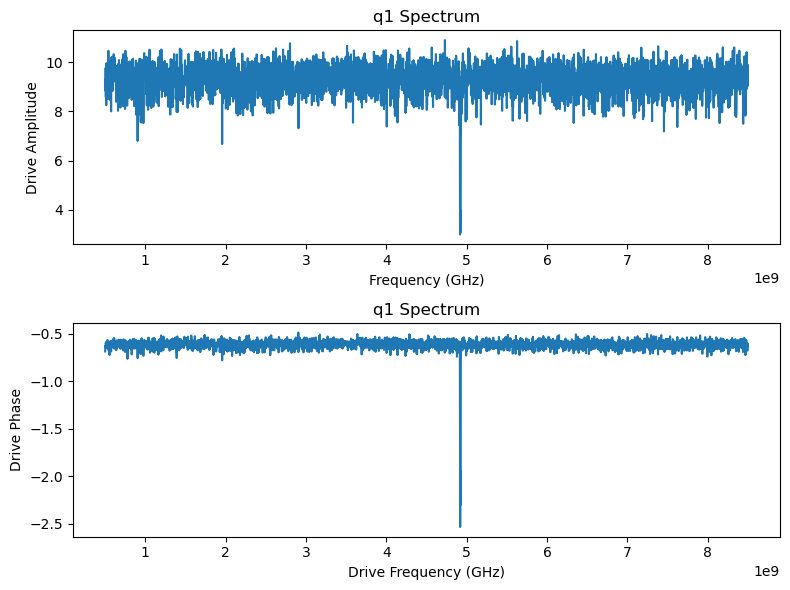

In [540]:
# For plotting current vs single resonator point
IQ_data = my_acquired_results.data.ravel()
amplitude = np.abs(IQ_data)
phase = np.angle(IQ_data)

fig, ax = plt.subplots(2,1, figsize=(8,6))
ax[0].plot(drive_freqs, amplitude)
ax[0].set_title(f'{qubit.uid} Spectrum')
ax[0].set_xlabel('Frequency (GHz)')
ax[0].set_ylabel('Amplitude')
ax[1].plot(drive_freqs, phase)
ax[1].set_title(f'{qubit.uid} Spectrum')
ax[1].set_xlabel('Drive Frequency (GHz)')
ax[1].set_ylabel('Phase')
fig.tight_layout()

# Qubit Spectroscopy (Local)

In [19]:
drive_freq_sweep = LinearSweepParameter(
    uid='Drive_Frequency',
    start=qubit.parameters.drive_frequency_ge-50e6,
    stop=qubit.parameters.drive_frequency_ge+50e6,
    count=201
)

exp = Experiment(
    uid="Spectroscopy",
    signals=[
        ExperimentSignal(uid="measure", map_to=lsg[qubit.uid]['measure_line']),
        ExperimentSignal(uid="acquire", map_to=lsg[qubit.uid]['acquire_line']),
        ExperimentSignal(uid="drive", map_to=lsg[qubit.uid]['drive_line'])
    ]
)

with exp.acquire_loop_rt(
    uid='shots',
    count=averages,
    averaging_mode=AveragingMode.SEQUENTIAL,
    acquisition_type=AcquisitionType.INTEGRATION,
):
    with exp.sweep(
        uid='Drive Frequency Sweep',
        parameter=drive_freq_sweep,
    ):
        with exp.section(uid='Play drive'):
            exp.play(
                signal="drive",
                pulse=pulse_library.gaussian_square(
                    uid=f"drive_spec_pulse_{qubit.uid}",
                    length=qubit.parameters.user_defined["pulse_length"],
                    amplitude=1), #qubit.parameters.user_defined['amplitude_pi']), #max power to start
            )
        with exp.section(
            uid="single_res_point_readout",
            play_after='Play drive',
        ):
            exp.play(
                signal="measure",
                pulse=readout_pulse)
            exp.acquire( #acquire on its own seems to be able to measure things, but not as well(?)
                signal='acquire',
                handle='single_freq_data',
                length=qubit.parameters.user_defined['readout_len'],
                kernel=readout_pulse #this is important to actually integrate against so the result is non-zero
            )
        with exp.section(uid="delay_between_readout", length=qubit.parameters.user_defined['reset_length']):
            exp.reserve(signal="measure")
            exp.reserve(signal="drive")

exp_calibration = Calibration()
drive_osc = Oscillator(
    "drive_osc",
    frequency=drive_freq_sweep,
    modulation_type=ModulationType.HARDWARE)
exp_calibration["drive"] = SignalCalibration(
    oscillator=drive_osc,)
exp.set_calibration(exp_calibration)

## Compile Session
Do final checks before running the job.

In [20]:
session = Session(
    device_setup=device_setup,
    log_level = logging.WARNING,
    experiment=exp)
session.connect();
compiled_session = session.compile(exp);
# psv.interactive_psv(compiled_session, max_events_to_publish=100,)

## Run session
- Think about how to implement session.queue() since this could allow the device to always be measuring something

In [21]:
results = session.run()
my_results = session.get_results() #a deep copy of session.results
my_acquired_results = my_results.acquired_results['single_freq_data'] #extracts data from the exp.acquire method with the same key name

## Plot and Analyze Data

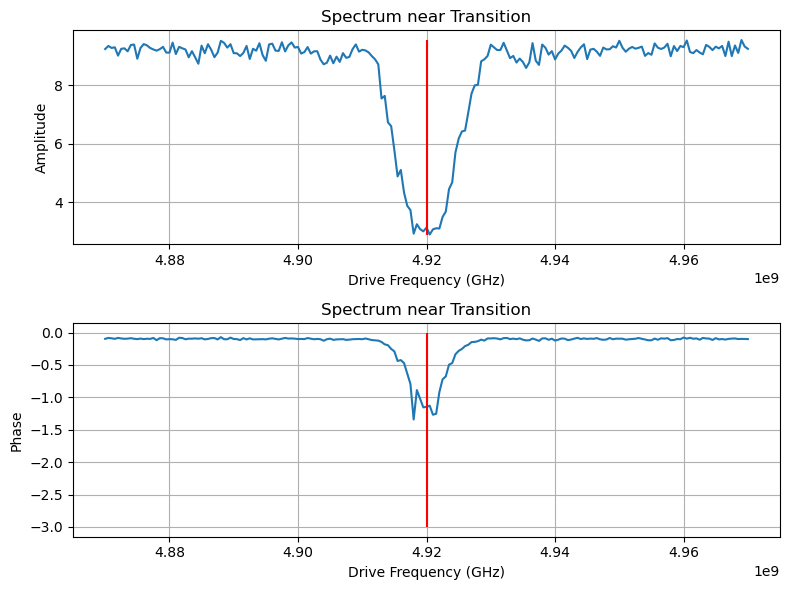

In [22]:
# For plotting current vs single resonator point
freqs = my_acquired_results.axis[0] + qubit.parameters.drive_lo_frequency
IQ_data = my_acquired_results.data
amplitude = np.abs(IQ_data)
phase = np.angle(IQ_data)

fig, ax = plt.subplots(2,1, figsize=(8,6))
ax[0].plot(freqs, amplitude)
ax[0].set_title('Spectrum near Transition')
ax[0].set_xlabel('Drive Frequency (GHz)')
ax[0].set_ylabel('Amplitude')
ax[0].grid()
ax[0].vlines(qubit.parameters.drive_frequency_ge+qubit.parameters.drive_lo_frequency, np.min(amplitude), np.max(amplitude), colors='r');
ax[1].plot(freqs, phase)
ax[1].set_title('Spectrum near Transition')
ax[1].set_xlabel('Drive Frequency (GHz)')
ax[1].set_ylabel('Phase')
ax[1].grid()
ax[1].vlines(qubit.parameters.drive_frequency_ge+qubit.parameters.drive_lo_frequency, -3, 0, colors='r');
fig.tight_layout()

# Qubit Spectroscopy Power Sweep (Nice-to-have but skip for now)

# Qubit T1

In [208]:
time_delay = LinearSweepParameter(
    uid='time_delay', start=0, stop=200e-6, count=40)

exp = Experiment(
    uid="Spectroscopy",
    signals=[
        ExperimentSignal(uid="measure", map_to=lsg[qubit.uid]['measure_line']),
        ExperimentSignal(uid="acquire", map_to=lsg[qubit.uid]['acquire_line']),
        ExperimentSignal(uid="drive", map_to=lsg[qubit.uid]['drive_line'])
    ]
)

with exp.acquire_loop_rt(
    uid='shots',
    count=averages,
    averaging_mode=AveragingMode.CYCLIC,
    acquisition_type=AcquisitionType.INTEGRATION,
):
    with exp.sweep(
        uid='Delay_sweep',
        parameter=time_delay,
    ):
        with exp.section(uid='Play drive'):
            exp.play(
                signal="drive",
                pulse=pulse_library.gaussian_square(
                    uid=f"drive_spec_pulse_{qubit.uid}",
                    length=qubit.parameters.user_defined["pulse_length"],
                    amplitude=qubit.parameters.user_defined['amplitude_pi']), #1,) #max power to start
            )
            exp.delay('drive', time_delay)
        with exp.section(
            uid="single_res_point_readout",
            play_after='Play drive',
        ):
            exp.play(
                signal="measure",
                pulse=readout_pulse)
            exp.acquire( #acquire on its own seems to be able to measure things, but not as well(?)
                signal='acquire',
                handle='single_freq_data',
                length=qubit.parameters.user_defined['readout_len'],
                kernel=readout_pulse #this is important to actually integrate against so the result is non-zero
            )
        with exp.section(uid="delay_between_readout", length=qubit.parameters.user_defined['reset_length']):
            exp.reserve(signal="measure")
            exp.reserve(signal="drive")

## Compile Session
Do final checks before running the job.

In [209]:
session = Session(
    device_setup=device_setup,
    log_level = logging.WARNING,
    experiment=exp)
session.connect();
compiled_session = session.compile(exp);
# psv.interactive_psv(compiled_session, max_events_to_publish=100,)

## Run session
- Think about how to implement session.queue() since this could allow the device to always be measuring something

In [210]:
results = session.run()
my_results = session.get_results() #a deep copy of session.results
my_acquired_results = my_results.acquired_results['single_freq_data'] #extracts data from the exp.acquire method with the same key name

## Plot and Analyze Data

Fitted parameters: [ 1.77717947e+04  9.76557785e+00 -7.14455547e+00]
T1 time 56.26893715180366 us


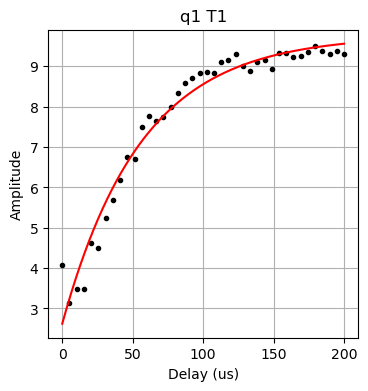

In [211]:
amplitude = np.abs(my_acquired_results.data)
phase = np.angle(my_acquired_results.data)

delay_plot = np.linspace(time_delay.start, time_delay.stop, 501)
popt, pcov = exponential_decay.fit(time_delay, amplitude, 1/3.4e-6, -20, -20, plot=False)

fig, ax = plt.subplots(1,1, figsize=(4,4))
ax.plot(time_delay*1e6, amplitude, '.k')
ax.plot(delay_plot*1e6, exponential_decay(delay_plot, *popt), '-r');
ax.set_title(f'{qubit.uid} T1')
ax.set_xlabel('Delay (us)')
ax.set_ylabel('Amplitude')
ax.grid()

print(f"Fitted parameters: {popt}")
print('T1 time ' + str(1/popt[0]*1e6) + ' us') 

# Qubit Rabi Amplitude Sweep (X Gate Tuneup)

In [236]:
rabi_amp_sweep = LinearSweepParameter(
    uid='rabi_amplitude', start=0, stop=1, count=40)

exp = Experiment(
    uid="Spectroscopy",
    signals=[
        ExperimentSignal(uid="measure", map_to=lsg[qubit.uid]['measure_line']),
        ExperimentSignal(uid="acquire", map_to=lsg[qubit.uid]['acquire_line']),
        ExperimentSignal(uid="drive", map_to=lsg[qubit.uid]['drive_line'])
    ]
)

with exp.acquire_loop_rt(
    uid='shots',
    count=averages,
    averaging_mode=AveragingMode.CYCLIC,
    acquisition_type=AcquisitionType.INTEGRATION,
):
    with exp.sweep(
        uid='Amplitude Sweep',
        parameter=rabi_amp_sweep,
    ):
        with exp.section(uid='Play drive'):
            exp.play(
                signal="drive",
                pulse=pulse_library.gaussian_square(
                    uid=f"drive_spec_pulse_{qubit.uid}",
                    length=qubit.parameters.user_defined["pulse_length"], #can have this be longer if not enough periods
                    amplitude=1,), #max power to start
                amplitude=rabi_amp_sweep,
            )
        with exp.section(
            uid="single_res_point_readout",
            play_after='Play drive',
        ):
            exp.play(
                signal="measure",
                pulse=readout_pulse)
            exp.acquire( #acquire on its own seems to be able to measure things, but not as well(?)
                signal='acquire',
                handle='single_freq_data',
                length=qubit.parameters.user_defined['readout_len'],
                kernel=readout_pulse #this is important to actually integrate against so the result is non-zero
            )
        with exp.section(uid="delay_between_readout", length=qubit.parameters.user_defined['reset_length']):
            exp.reserve(signal="measure")
            exp.reserve(signal="drive")

## Compile Session
Do final checks before running the job.

In [237]:
session = Session(
    device_setup=device_setup,
    log_level = logging.WARNING,
    experiment=exp)
session.connect();
compiled_session = session.compile(exp);
# psv.interactive_psv(compiled_session, max_events_to_publish=100,)

## Run session
- Think about how to implement session.queue() since this could allow the device to always be measuring something

In [238]:
results = session.run()
my_results = session.get_results() #a deep copy of session.results
my_acquired_results = my_results.acquired_results['single_freq_data'] #extracts data from the exp.acquire method with the same key name

## Plot and Analyze Data

Fitted parameters: [ 3.93200966 -3.50434735 -3.02040569  6.17042252]


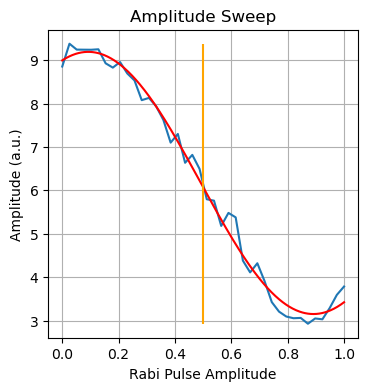

In [239]:
# plot measurement data
drive_amp = my_acquired_results.axis[0]
rabi_data = my_acquired_results.data
rabi_data_abs = np.abs(rabi_data)
rabi_data_phase = np.angle(rabi_data)

fitting_plot_x = np.linspace(rabi_amp_sweep.start, rabi_amp_sweep.stop, 501)
popt, pcov = oscillatory.fit(rabi_amp, rabi_data_abs, 2, -3, 0, 8, plot=False)

fig, ax = plt.subplots(1, 1, figsize=(4,4))
ax.plot(drive_amp, rabi_data_abs)
ax.plot(fitting_plot_x, oscillatory(fitting_plot_x, *popt), '-r')
ax.set_title('Amplitude Sweep')
ax.set_xlabel('Rabi Pulse Amplitude')
ax.set_ylabel('Amplitude (a.u.)')
ax.vlines(0.5, ymin=np.min(rabi_data_abs), ymax=np.max(rabi_data_abs), color='orange')
ax.grid()
print(f"Fitted parameters: {popt}")

# Qubit Ramsey

In [240]:
time_delay = LinearSweepParameter(
    uid='time_delay', start=0, stop=20e-6, count=201)

ramsey_drive = pulse_library.gaussian_square(
    uid='ramsey_drive',
    length=qubit.parameters.user_defined['pulse_length'],
    amplitude=qubit.parameters.user_defined['amplitude_pi/2'],
)

exp = Experiment(
    uid="Spectroscopy",
    signals=[
        ExperimentSignal(uid="measure", map_to=lsg[qubit.uid]['measure_line']),
        ExperimentSignal(uid="acquire", map_to=lsg[qubit.uid]['acquire_line']),
        ExperimentSignal(uid="drive", map_to=lsg[qubit.uid]['drive_line'])
    ]
)

with exp.acquire_loop_rt(
    uid='shots',
    count=averages,
    averaging_mode=AveragingMode.CYCLIC,
    acquisition_type=AcquisitionType.INTEGRATION,
):
    with exp.sweep(
        uid='Delay_sweep',
        parameter=time_delay,
    ):
        with exp.section(uid='Play drive'):
            exp.play(signal="drive", pulse=ramsey_drive)
            exp.delay('drive', time_delay)
            exp.play(signal="drive", pulse=ramsey_drive)
        with exp.section(
            uid="single_res_point_readout",
            play_after='Play drive',
        ):
            exp.play(
                signal="measure",
                pulse=readout_pulse)
            exp.acquire( #acquire on its own seems to be able to measure things, but not as well(?)
                signal='acquire',
                handle='single_freq_data',
                length=qubit.parameters.user_defined['readout_len'],
                kernel=readout_pulse #this is important to actually integrate against so the result is non-zero
            )
        with exp.section(uid="delay_between_readout", length=qubit.parameters.user_defined['reset_length']):
            exp.reserve(signal="measure")
            exp.reserve(signal="drive")

exp_calibration = Calibration()
drive_osc = Oscillator(
    "drive_osc",
    frequency=qubit.parameters.drive_frequency_ge+1e6, #offset here of about 1MHz to 3MHz to get precise frequency
    modulation_type=ModulationType.HARDWARE)
exp_calibration["drive"] = SignalCalibration(
    oscillator=drive_osc,)
exp.set_calibration(exp_calibration)

## Compile Session
Do final checks before running the job.

In [241]:
session = Session(
    device_setup=device_setup,
    log_level = logging.WARNING,
    experiment=exp)
session.connect();
compiled_session = session.compile(exp);
# psv.interactive_psv(compiled_session, max_events_to_publish=100,)

## Run session
- Think about how to implement session.queue() since this could allow the device to always be measuring something

In [242]:
results = session.run()
my_results = session.get_results() #a deep copy of session.results
my_acquired_results = my_results.acquired_results['single_freq_data'] #extracts data from the exp.acquire method with the same key name

## Plot and Analyze Data

[2024.10.30 16:28:40.840] WARNING C:\Users\QNL\anaconda3\Lib\site-packages\laboneq\dsl\parameter.py:85: RuntimeWarning: overflow encountered in exp
  values = ufunc(*new_inputs)

Fitted parameters: [6.03743931e+06 2.91075928e+01 2.98162839e+04 2.54060552e+00
 5.16855639e+00]
detuning = 6.037439311813862 MHz, T2r = 33.538720104375024 us


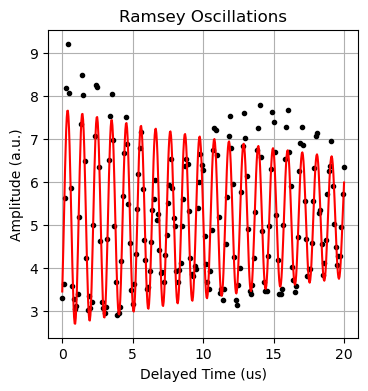

In [243]:
ramsey_data = my_acquired_results.data
ramsey_data_abs = np.abs(ramsey_data)
ramsey_data_phase = np.angle(ramsey_data)

fitting_plot_x = np.linspace(time_delay.start, time_delay.stop, 501)
popt, pcov = oscillatory_decay.fit(time_delay, ramsey_data_abs, 7e6, 2, 4, 0.01, -24, plot=False)

fig, ax = plt.subplots(1, 1, figsize=(4,4))
ax.plot(time_delay*1e6, ramsey_data_abs, '.k')
ax.plot(fitting_plot_x*1e6, oscillatory_decay(fitting_plot_x, *popt), '-r')
ax.set_title('Ramsey Oscillations')
ax.set_xlabel('Delayed Time (us)')
ax.set_ylabel('Amplitude (a.u.)')
ax.grid()

print(f'Fitted parameters: {popt}')
#NOTE: you need to divide the detuning by 2pi when adjusting for later measurements
print(f'detuning = {popt[0]*1e-6} MHz, T2r = {1e6/popt[2]} us')

# T2 Echo

In [248]:
time_delay = LinearSweepParameter(
    uid='time_delay', start=0, stop=2e-4, count=51)

x90 = pulse_library.gaussian_square(
    uid='x90',
    length=qubit.parameters.user_defined['pulse_length'],
    amplitude=qubit.parameters.user_defined['amplitude_pi/2']
)

x180 = pulse_library.gaussian_square(
    uid='x180',
    length=qubit.parameters.user_defined['pulse_length'],
    amplitude=qubit.parameters.user_defined['amplitude_pi']
)

exp = Experiment(
    uid="Spectroscopy",
    signals=[
        ExperimentSignal(uid="measure", map_to=lsg[qubit.uid]['measure_line']),
        ExperimentSignal(uid="acquire", map_to=lsg[qubit.uid]['acquire_line']),
        ExperimentSignal(uid="drive", map_to=lsg[qubit.uid]['drive_line'])
    ]
)

with exp.acquire_loop_rt(
    uid='shots',
    count=averages,
    averaging_mode=AveragingMode.CYCLIC,
    acquisition_type=AcquisitionType.INTEGRATION,
):
    with exp.sweep(
        uid='Delay_sweep',
        parameter=time_delay,
    ):
        with exp.section(uid='Play drive'):
            exp.play(signal="drive", phase=0, pulse=x90)
            exp.delay('drive', time_delay/2)
            exp.play(signal="drive", phase=0, pulse=x180)
            exp.delay('drive', time_delay/2)
            exp.play(signal='drive', phase=0, pulse=x90)
        with exp.section(
            uid="single_res_point_readout",
            play_after='Play drive',
        ):
            exp.play(
                signal="measure",
                pulse=readout_pulse)
            exp.acquire( #acquire on its own seems to be able to measure things, but not as well(?)
                signal='acquire',
                handle='single_freq_data',
                length=qubit.parameters.user_defined['readout_len'],
                kernel=readout_pulse #this is important to actually integrate against so the result is non-zero
            )
        with exp.section(uid="delay_between_readout", length=qubit.parameters.user_defined['reset_length']):
            exp.reserve(signal="measure")
            exp.reserve(signal="drive")

exp_calibration = Calibration()
drive_osc = Oscillator(
    "drive_osc",
    frequency=qubit.parameters.drive_frequency_ge+1e6-0.96e6,
    modulation_type=ModulationType.HARDWARE)
exp_calibration["drive"] = SignalCalibration(
    oscillator=drive_osc,)
exp.set_calibration(exp_calibration)

## Compile Session
Do final checks before running the job.

In [249]:
session = Session(
    device_setup=device_setup,
    log_level = logging.WARNING,
    experiment=exp)
session.connect();
compiled_session = session.compile(exp);
# psv.interactive_psv(compiled_session, max_events_to_publish=100,)

## Run session
- Think about how to implement session.queue() since this could allow the device to always be measuring something

In [250]:
results = session.run()
my_results = session.get_results() #a deep copy of session.results
my_acquired_results = my_results.acquired_results['single_freq_data'] #extracts data from the exp.acquire method with the same key name

## Plot and Analyze Data

Fitted parameters: [8.19797505e+04 4.72581814e+00 8.30512418e+00]
T2e time 12.198134222879654 us


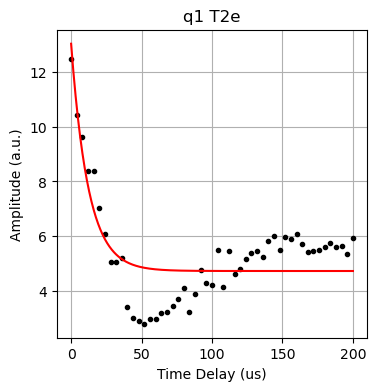

In [251]:
echo_data = my_acquired_results.data
echo_data_abs = np.abs(echo_data)
echo_data_phase = np.angle(echo_data)

popt, pcov = exponential_decay.fit(time_delay, echo_data_abs, (1/30e-6), -20, -20, plot=False)
fit_plotting_x = np.linspace(time_delay.start, time_delay.stop, 501)

fig, ax = plt.subplots(1, 1, figsize=(4,4))
ax.plot(time_delay*1e6, echo_data_abs, '.k')
ax.plot(fit_plotting_x*1e6, exponential_decay(fit_plotting_x, *popt), '-r')
ax.set_title(f'{qubit.uid} T2e')
ax.set_xlabel('Time Delay (us)')
ax.set_ylabel('Amplitude (a.u.)')
ax.grid()

print(f"Fitted parameters: {popt}")
print('T2e time ' + str(1/popt[0]*1e6) + ' us') 

# Notes about above sections

## Plot and Analyze Data

## Defining an Experiment
Here, signal mapping sets a label of how the "ExperimentSignal" maps to ("map_to") the logical signal groups of each qubit.

## Calibration for the Experiment
- Would ideally have calibration ala the device_setup instead of through the experiment calibration
- Would also like to add a delay to the calibration of all this instead of having it be through a manual readout pulse delay
- Should have a time stamp and fractional counter each time the current updates to have a sense of progress
- Think of a way to usably implement session.abort_execution()...

## Compile Session
Do final checks before running the job.

## Run session
- Think about how to implement session.queue() since this could allow the device to always be measuring something

# Work in progress code